In [13]:
import local_seqtools.general_utils as tools
import pandas as pd
import numpy as np
import local_conservation_analysis_pipeline.group_conservation_objects as group_tools
import json
import os
import re
import sys
from pathlib import Path
from Bio import AlignIO, Seq, SeqIO, Align
import seaborn as sns
from sklearn import metrics
from local_seqtools import pssms
import logomaker as lm
from ast import literal_eval
import local_conservation_scores.tools.pairwise_tools as pairwise_tools
import local_conservation_scores.tools.score_plots as score_plots
from dataclasses import dataclass

import matplotlib.pyplot as plt
plt.style.use('custom_standard')
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
tablefile = "../../benchmark/benchmark_v3/p3_conservation/benchmark_table_renamed_ANNOTATED.csv"
df = pd.read_csv(tablefile)

In [6]:
SCORE_KEYS = [
    'aln_property_entropy',
    'fragpair_gapless_lf5_rf5_edssmat50',
    'frag_pairwise_gapless_embedding_lf5_rf5',
]

In [29]:
@dataclass
class PairwiseScoreResults:
    flanked_hit: str
    flanked_hit_start_position_in_idr: int
    original_hit_st_in_flanked_hit: int
    original_hit_end_in_flanked_hit: int
    score_function_name: str
    score_params: dict
    lflank: int
    rflank: int
    matrix_file: str|Path
    flanked_hit_sequence: str
    flanked_hit_scores: list
    flanked_hit_z_scores: list
    hit_sequence: str
    hit_scores: list
    hit_z_scores: list
    mat2score_params: dict


@dataclass
class AlnScoreResults:
    file: str
    score_function_name: str
    score_params: dict
    hit_scores: list
    hit_z_scores: list


def slice_aln_scores(lvlo: group_tools.LevelAlnScore, aln_start, aln_end):
    hit_slice = slice(aln_start, aln_end + 1)
    hit_scores = lvlo.scores[hit_slice]
    hit_z_scores = lvlo.z_scores[hit_slice]
    hit_aln_seq = lvlo.query_aln_sequence[hit_slice]
    return hit_scores, hit_z_scores, hit_aln_seq

def json2logoplot_alnscore(jsonfile, score_key, with_gaps=False, axes=None, level='Vertebrata', flank=5):
    og = group_tools.ConserGene(jsonfile)
    lvlo = og.get_aln_score_obj(level, score_key)
    # aln = jch_alignment.jch_alignment(lvlo.aln, og.query_gene_id)
    flst, flend, flhit=tools.pad_hit(og.query_idr_sequence, og.hit_st_in_idr, og.hit_end_in_idr, l_flank=flank, r_flank=flank)
    query_idr, index = tools.reindex_alignment_str(lvlo.query_aln_sequence[lvlo.idr_aln_start:lvlo.idr_aln_end+1])
    flstaln, flendaln = index[flst], index[flend]
    flanked_hit_scores, flanked_hit_z_scores, flhit_aln_seq = slice_aln_scores(lvlo, flstaln+lvlo.idr_aln_start, flendaln+lvlo.idr_aln_start)
    idr_aln = lvlo.aln[:, lvlo.idr_aln_start:lvlo.idr_aln_end+1]
    flhit_aln = idr_aln[:, flstaln:flendaln+1]

    if not with_gaps:
        seqlist, query_slice, nongapinds = score_plots.strip_gaps_from_slice(flhit_aln, flhit_aln_seq)
        score_list = list(np.array(flanked_hit_z_scores)[nongapinds])
    else:
        seqlist=[str(i.seq) for i in list(flhit_aln)]
        query_slice = flhit_aln_seq
        score_list = flanked_hit_z_scores
    if axes is None:
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 4))
    score_plots.plot_score_bar_plot(
        ax=axes[0],
        score_list=score_list,
        query_seq=query_slice,
    )
    score_plots.plot_logo(
        ax=axes[1], str_list=seqlist, tick_label_str=query_slice,
    )
    counts = pssms.alignment_2_counts(
        seqlist, show_plot=False, heatmap=False
    )
    return counts

def json2logoplot(jsonfile, score_key, rbm: bool = False, axes=None, level='Vertebrata'):
    og = group_tools.ConserGene(jsonfile)
    lvlo = og.get_level_obj(level)
    mat_dict = pairwise_tools.import_pairwise_matrices(
        lvlo.conservation_scores[score_key]["matrix_file"]
    )
    result = PairwiseScoreResults(**lvlo.conservation_scores[score_key])
    subseqdf = mat_dict["subseq_dataframe"]
    subseqdf=subseqdf.fillna('-'*len(result.flanked_hit))
    if rbm:
        rbmdf = mat_dict["reciprocal_best_match_dataframe"]
        rbmdf=rbmdf.fillna(False)
        hitdf = pd.concat(
            [
                subseqdf.loc[result.flanked_hit_start_position_in_idr],
                rbmdf.loc[result.flanked_hit_start_position_in_idr],
            ],
            axis=1,
            keys=["subseq", "rbm"],
        )
        hitdf.loc["reference_kmer", "rbm"] = True
        seqlist = hitdf[hitdf["rbm"]]["subseq"].to_list()
    else:
        seqlist = subseqdf.loc[result.flanked_hit_start_position_in_idr].to_list()
    if axes is None:
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 4))
    if not rbm:
        score_plots.plot_score_bar_plot(
            ax=axes[0],
            score_list=result.flanked_hit_z_scores,
            query_seq=result.flanked_hit_sequence,
        )
    score_plots.plot_logo(
        ax=axes[1], str_list=seqlist, tick_label_str=result.flanked_hit_sequence
    )
    counts = pssms.alignment_2_counts(
        seqlist, show_plot=False, heatmap=False
    )
    return counts, result

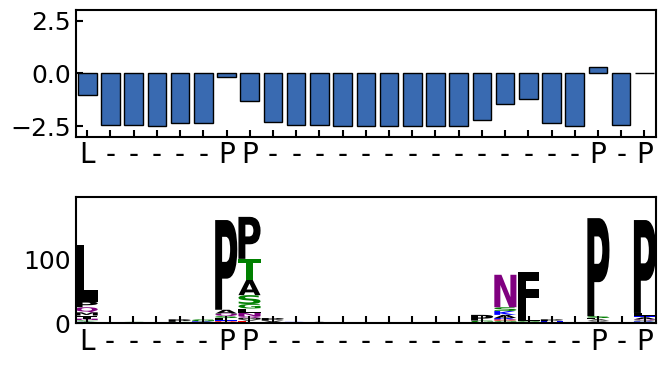

In [41]:
temp=df[df['reference_index']==2243].copy()
fig, axes = plt.subplots(nrows=2, figsize=(7, 4))
_ = json2logoplot_alnscore(temp['json_file'].values[0], 'aln_property_entropy', axes=axes, level='Vertebrata', with_gaps=True, flank=0)
axes[0].set_ylim([-3, 3])
for ax in axes:
    ax.tick_params(axis="x", which="major", labelsize=20)
plt.tight_layout()
plt.savefig('logo-RIAM-MSA_with_gaps.png', bbox_inches='tight', dpi=300)

In [37]:
def plots_from_df(df, level):
    for i, row in df.iterrows():
        jsonfile = row['json_file']
        fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(13, 4))
        _=json2logoplot_alnscore(jsonfile, 'aln_property_entropy', axes=ax[:,0], level=level, with_gaps=False, flank=0)
        _=json2logoplot(jsonfile, 'fragpair_gapless_lf0_rf0_edssmat50', rbm=False, axes=ax[:,1], level=level)
        _=json2logoplot(jsonfile, 'frag_pairwise_gapless_embedding_lf0_rf0', rbm=False, axes=ax[:,2], level=level)
        for axi in ax[0,:]:
            axi.set_ylim([-3, 3])
        plt.tight_layout()
    return fig, ax

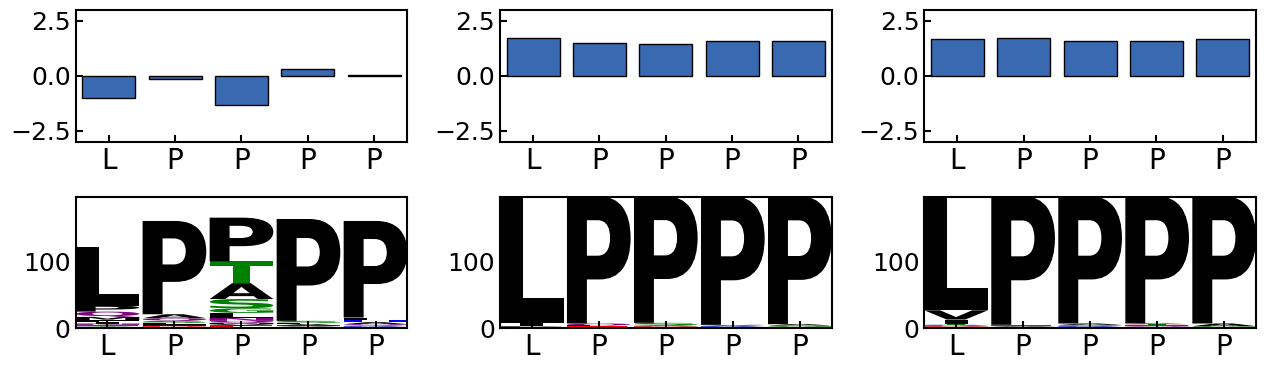

In [39]:
fig, axes = plots_from_df(temp, 'Vertebrata')
for ax in axes.flatten():
    ax.tick_params(axis="x", which="major", labelsize=20)
plt.savefig('logo-RIAM-MSA_pairk_pairkembedding.png', bbox_inches='tight', dpi=300)

In [ ]:
temp=vert_df[vert_df['reference_index']==2243].copy()
fig, ax = plt.subplots(nrows=2, figsize=(8, 4))
_=json2logoplot_alnscore(temp['json_file'].values[0], 'aln_property_entropy', axes=ax, level='Vertebrata', with_gaps=True, flank=0)
ax[0].set_ylim([-3, 3])
plt.tight_layout()

In [ ]:
vert_df.sort_values('aln-pair', ascending=False).head(10)
temp=vert_df[vert_df['aln-pair']>2].copy()
temp=temp[~temp['UniprotID'].isna()]
plots_from_df(temp[temp['verified interaction']].sort_values('mean_score_fragpair_gapless_lf5_rf5_edssmat50', ascending=False).head(10), 'Vertebrata')